<a href="https://colab.research.google.com/github/rosellaliu/cs300-lectures/blob/main/research_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# The Research Assignment:
Social media has become a powerful tool to conduct analysis on social... and ... In this project you will leverage skills that you have learnt in the past few weeks, such as Topic Modeling, Latent Sentiment Analysis, Word embedding, to build a small model analyzing the relationships between political opinions and regions, social media presence, self-identifications of tweeter users on various kinds of political issues. In the last section of this project, you will also pick up *plotly*, a powerful visualization tool that allow you to disocver underlying correlations between words, sentences and sentiments. All of the skills that you will garner through this project will surely contribute to your further understanding of Computational Linguistics as a field with expanding usage and hopefully lay good foundation for your success in the final project and future opportunities. 

# Topic modeling using LSA (Latent Semantic Analysis)

Latent Semantic Analysis is a CL method that allows us to extract topics from 
documents by converting the text into word-topic and document-topic matrices. 

The procedure for LSA can be described into the following three steps:
1. Convert the text corpus into a document-term matrix, I did it with bag of words. 
2. Implement truncated singular value decomposition, manifested in code section.
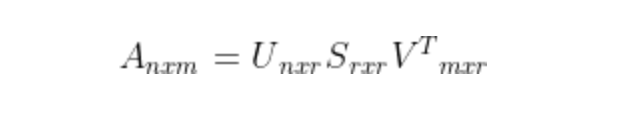

3. Encode the words/documents with the extracted topics. For this section, we mainly look at the U matrix (document-topic matrix) and the V matrix (word-topic matrix) of the SVM operation, and decide which words are more relevant for each topics. S matrix (shows the strength between each word and derived topic) is not important here. 


# Import and Setting

In [3]:
# kaggle installation
! pip install kaggle

# make a new directory named kaggle
! mkdir ~/.kaggle

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Copy the “kaggle.json” into this new directory
! cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/

# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

# download the specific kaggle dataset : Global political tweets
! kaggle datasets download -d kaushiksuresh147/political-tweets
#! kaggle datasets download paolodelia/finance-subreddits -f finance_subreddit.csv 

# unzip the downloaded document
! unzip Political_tweets.csv.zip

# import sklearn and other packages
%matplotlib inline

! pip install -U pip setuptools wheel

! pip install -U spacy

! python -m spacy validate

! pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
political-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open Political_tweets.csv.zip, Political_tweets.csv.zip.zip or Political_tweets.csv.zip.ZIP.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached spacy-3.4.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.3 MB)
  Using cached thinc-8.1.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (821 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:

# Load Data

In [2]:
# import pandas
import pandas as pd

# read the file 
df = pd.read_csv('Political_tweets.csv', header=1)

# df = pd.read_csv('Political_tweets.csv', 
#                  usecols= ['user_name', 'user_location', 
#                            'user_description', 'user_created', 
#                            'user_follows', 'user_friends', 
#                            'user_favourites', 'user_verified', 
#                            'date', 'text', 'hashtags', 'source', 'is_retweet'],
#                             sep=';', error_bad_lines=False)
print("Size of df:", df.size) 
print("Shape of df (rows x columns)", df.shape)
df.head() # only showing 5 lines of the file



FileNotFoundError: ignored

# Preprocessing Data

In [11]:
# new spacy preprocessing 
import spacy
import re
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(df["selftext"].fillna("").astype(str)))

def is_token_allowed(token):
  if (not token or not token.text.strip() or 
      token.is_stop or token.is_punct):
    return False
  else:
    return True

def preprocess_token(token):
  # Reduce token to its lowercase lemma form
  return token.lemma_.strip().lower()

def document_helper(docs):
  for doc in docs:
    [preprocess_token(token) for token in doc if is_token_allowed(token)]

df['cleaned selftext'] = document_helper(docs)
df.head()

In [3]:
# # we will use mainly spacy and nltk for the preprocessing # simpler 
# import spacy
# from spacy.lang.en import English

# import re

# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import SnowballStemmer
# from nltk.tokenize import WhitespaceTokenizer

# from sklearn.preprocessing import FunctionTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer

# # stopwords define
# spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# def pipelinize(function, active=True):
#     def list_comprehend_a_function(list_or_series, active=True):
#         if active:
#             return [function(i) for i in list_or_series]
#         else: # if it's not active, just pass it right back
#             return list_or_series
#     return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


# def w_tokenizer(text):
#     tokenizer = WhitespaceTokenizer()   
#     # Use tokenize method 
#     tokenized_list = tokenizer.tokenize(text) 
#     return(tokenized_list)

# def stemmer_snowball(text_list):
#     snowball = SnowballStemmer(language='english')
#     return_list = []
#     for i in range(len(text_list)):
#         return_list.append(snowball.stem(text_list[i]))
#     return(return_list)

# def remove_stopwords(text_list):
#     return_list = []
#     for i in range(len(text_list)):
#         if text_list[i] not in spacy_stopwords:
#             return_list.append(text_list[i])
#     return(return_list)

# def remove_punctuation(text):
#     if isinstance((text), (str)):
#         text = re.sub('<[^>]*>', '', text)
#         text = re.sub('[\W]+', '', text.lower())
#         return text
#     if isinstance((text), (list)):
#         return_list = []
#         for i in range(len(text)):
#             temp_text = re.sub('<[^>]*>', '', text[i])
#             temp_text = re.sub('[\W]+', '', temp_text.lower())
#             return_list.append(temp_text)
#         return(return_list)
#     else:
#         pass

# estimators = [('tokenizer', pipelinize(w_tokenizer)), 
#               ('stemmer', pipelinize(stemmer_snowball)),
#               ('stopwordremoval', pipelinize(remove_stopwords)), 
#               ('remove_punctuation', pipelinize(remove_punctuation))]

# pipe = Pipeline(estimators)
# df['cleaned selftext'] = pipe.transform(df['selftext'].fillna("").astype(str))
# df.head()

,id,title,url,created_utc,score,num_comments,selftext,cleaned selftext
0,nuwzi7,AOL 90s VS AMC 21,https://i.redd.it/c08fr2nf6z371.jpg,1.623129e+09,1.0,0.0,NaN,[]
1,nutm2u,"Moronic Monday - June 08, 2021 - Your Weekly Q...",https://www.reddit.com/r/finance/comments/nutm...,1.623118e+09,1.0,0.0,This is your safe place for questions on finan...,"[safe, place, question, financi, careers, home..."
2,nut6qz,The Form 2290 Tax Year,http://blog.taxseer2290.com/what-is-your-form-...,1.623116e+09,1.0,0.0,NaN,[]
3,nut34x,PayAlly: Taps Banking Circle to hit more payme...,https://www.fintechinshorts.com/payally-taps-b...,1.623116e+09,1.0,0.0,NaN,[]
4,nus06s,"""In Texas we call that stealin'!"" Wes Christia...",https://v.redd.it/sf0x071wsx371,1.623112e+09,1.0,0.0,NaN,[]


# Building the LSA Model - 1: Generate TF-IDF Features

In [11]:

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# you could use Tfidfvectorizer to do preprocessing...
#Depending on the objective of the project
# max_feature is something you can play with
vect = TfidfVectorizer(max_features=1000) 
train_data = vect.fit_transform(df['cleaned selftext'].astype(str)) #expects an array of strings

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(max_features=1000)>

# Building the LSA Model - 2: Perform SVD & Extract topics and terms
*Question: do we want students to do coherence score analysis here?*

In [6]:
# Define the number of topics or components
num_components= 5

for i in range (1, num_components + 1):
  # Create SVD object
  lsa = TruncatedSVD(n_components= i, n_iter=100, random_state=42)
  # Fit SVD model on data
  U = lsa.fit_transform(train_data)
  # Get Singular values and Components 
  Sigma = lsa.singular_values_ 
  V_transpose = lsa.components_.T

  # Print the topics with their terms
  terms = vect.get_feature_names()
  print("\n ---- Extracting topics and terms for " + str(i) + " classifications ------ \n")
  for index, component in enumerate(lsa.components_):
      zipped = zip(terms, component)
      top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
      top_terms_list=list(dict(top_terms_key).keys())
      print("Topic "+str(index)+": ",top_terms_list)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



 ---- Extracting topics and terms for 1 classifications ------ 

Topic 0:  ['removed', 'articl', 'unplan', 'post', 'knowledg']

 ---- Extracting topics and terms for 2 classifications ------ 

Topic 0:  ['removed', 'articl', 'unplan', 'post', 'knowledg']
Topic 1:  ['deleted', 'contribut', 'link', 'future', 'post']

 ---- Extracting topics and terms for 3 classifications ------ 

Topic 0:  ['removed', 'articl', 'unplan', 'post', 'knowledg']
Topic 1:  ['deleted', 'contribut', 'link', 'future', 'post']
Topic 2:  ['loan', 'cash', 'ani', 'credit', 'financi']

 ---- Extracting topics and terms for 4 classifications ------ 

Topic 0:  ['removed', 'articl', 'unplan', 'post', 'knowledg']
Topic 1:  ['deleted', 'contribut', 'link', 'future', 'post']
Topic 2:  ['loan', 'cash', 'ani', 'credit', 'financi']
Topic 3:  ['im', 'financ', 'like', 'know', 'question']

 ---- Extracting topics and terms for 5 classifications ------ 

Topic 0:  ['removed', 'articl', 'unplan', 'post', 'knowledg']
Topic 1:  ['

# Visualization
*pyLDAvis' data structure problem is such a pain, scratch that we are going to use plotly for this project*

In [10]:
# pip install pyLDAvis
# import pyLDAvis
# import pyLDAvis.sklearn
# pyLDAvis.enable_notebook()

# topic_term_dists = np.vectorize(V_transpose)
# doc_topic_dists = np.vectorize(U)
# term_frequency = np.vectorize(Sigma)
# #build
# pyLDAvis.sklearn.prepare(topic_term_dists, doc_topic_dists, term_frequency)


AttributeError: ignored

# Useful Resources

1.   Building the sklearn pipeline:
https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/

2.   Building LSA model:

3.   Projects using LSA:
*  Literature corpus analysis:https://msaxton.github.io/topic-model-best-practices/project_overview.html 
*   List of possible Topic Modeling Topics:
https://medium.com/@neala/a-review-of-topic-modeling-projects-941922a1216c




